## Context:
  - This is Kaggle(News Headlines dataset for Sarcasm Detection) contains 26709 Text_Headlines of News Article with labels of whether they are Sarcastic or not with hyperlink of the articles from where the comment is extracted.
  - We need to make a model which can predict if the sentence/Headline given contains sarcasm or not
  - This kind of models will help to predict trolling in news-Media by detecting whether article headline contains sarcasm or not.

## Content of Dataset:
Each record consists of three attributes:
-  is_sarcastic: 1 if the record is sarcastic otherwise 0
-  headline: the headline of the news article
-  article_link: link to the original news article. Useful in collecting supplementary data

## 1.Downloading Dataset

In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2021-03-02 14:43:16--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.206.128, 64.233.167.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.206.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.07s   

2021-03-02 14:43:16 (80.7 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



## 1.Importing libraries

In [29]:
import json
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Loading Dataset in our system

In [6]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)
print(datastore[:10])

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}, {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365', 'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse", 'is_sarcastic': 0}, {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697', 'headline': "mom starting to fear son's web series closest thing she will have to grandchild", 'is_sarcastic': 1}, {'article_link': 'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302', 'headline': 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas', 'is_sarcastic': 1}, {'article_link': 'https://www.huffingtonpost.com/entry/jk-rowling-wishes-snape-happy-bi

In [31]:
len(datastore)

26709

#### Contains 26709 Text sentences with labels and article_link 

# 2.Splitting data into training/testing set and features/labels

In [69]:
sentences = []
labels = []
                            #Extracting Headlines and labels from dataset
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [8]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# 3.Tokenizing and Padding

In [30]:
#Defining Hyperparameters
vocab_size = 10000 
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [33]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences) #Tokenzing
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)#padding

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

import numpy as np  # converting into numpy array
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

# 4.Modelling

### Model1: General DNN Model

In [38]:
model1= tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [57]:
history1 = model1.fit(training_padded, training_labels, epochs=5, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/5
625/625 - 3s - loss: 0.1088 - accuracy: 0.9621 - val_loss: 0.4584 - val_accuracy: 0.8451
Epoch 2/5
625/625 - 3s - loss: 0.0994 - accuracy: 0.9665 - val_loss: 0.4869 - val_accuracy: 0.8420
Epoch 3/5
625/625 - 3s - loss: 0.0910 - accuracy: 0.9693 - val_loss: 0.5153 - val_accuracy: 0.8393
Epoch 4/5
625/625 - 3s - loss: 0.0814 - accuracy: 0.9730 - val_loss: 0.5420 - val_accuracy: 0.8384
Epoch 5/5
625/625 - 3s - loss: 0.0758 - accuracy: 0.9744 - val_loss: 0.5839 - val_accuracy: 0.8335


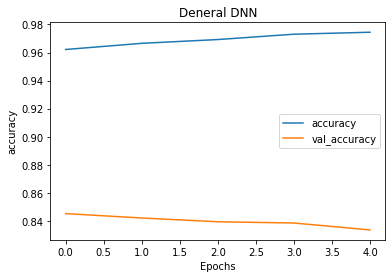

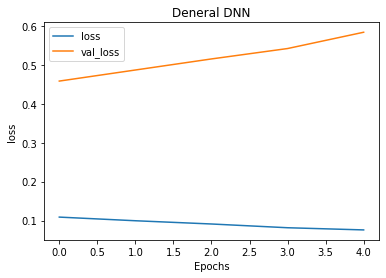

In [87]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history1.history[string])
  plt.plot(history1.history['val_'+string])
  plt.title('Deneral DNN')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history1, "accuracy")
plot_graphs(history1, "loss")

### Overfitting from starting

## Model2: Using LSTM

In [71]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,dropout=0.3)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 100, 16)           160000    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 12)                1104      
_________________________________________________________________
dropout_6 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                130       
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 11        
Total params: 161,245
Trainable params: 161,245
Non-trainable params: 0
_______________________________________________

In [84]:
history2=model2.fit(training_padded,training_labels,validation_data=(testing_padded,testing_labels),epochs=5)

Epoch 1/5
625/625 [==============================] - 36s 53ms/step - loss: 0.6254 - accuracy: 0.6289 - val_loss: 0.3565 - val_accuracy: 0.8472
Epoch 2/5
625/625 [==============================] - 32s 52ms/step - loss: 0.3333 - accuracy: 0.8773 - val_loss: 0.3420 - val_accuracy: 0.8524
Epoch 3/5
625/625 [==============================] - 32s 52ms/step - loss: 0.2418 - accuracy: 0.9191 - val_loss: 0.3599 - val_accuracy: 0.8530
Epoch 4/5
625/625 [==============================] - 33s 52ms/step - loss: 0.1881 - accuracy: 0.9382 - val_loss: 0.4307 - val_accuracy: 0.8477
Epoch 5/5
625/625 [==============================] - 32s 52ms/step - loss: 0.1611 - accuracy: 0.9486 - val_loss: 0.4358 - val_accuracy: 0.8505


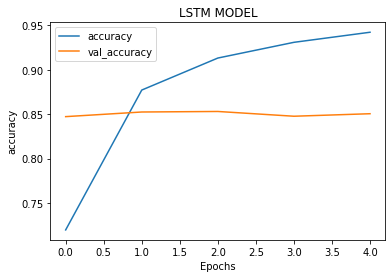

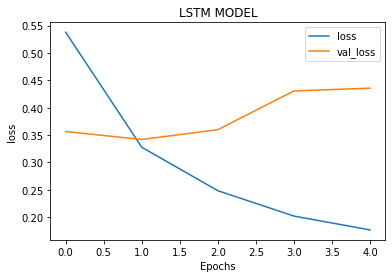

In [86]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history2.history[string])
  plt.plot(history2.history['val_'+string])
  plt.title('LSTM MODEL')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

## Model3: Using LSTM+GRU Layer

In [79]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(8,dropout=0.3,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,dropout=0.3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#model.summary()


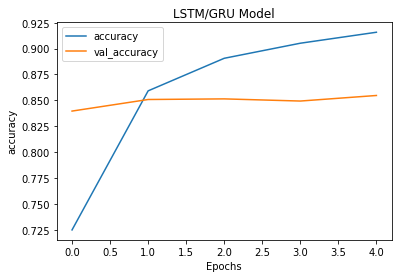

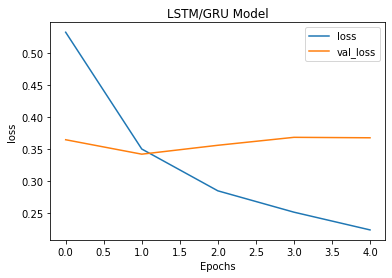

In [88]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history3.history[string])
  plt.plot(history3.history['val_'+string])
  plt.title('LSTM/GRU Model')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history3, "accuracy")
plot_graphs(history3, "loss")

In [80]:
history3=model3.fit(training_padded,training_labels,validation_data=(testing_padded,testing_labels),epochs=5)

Epoch 1/5
625/625 [==============================] - 75s 112ms/step - loss: 0.6209 - accuracy: 0.6378 - val_loss: 0.3644 - val_accuracy: 0.8396
Epoch 2/5
625/625 [==============================] - 68s 109ms/step - loss: 0.3522 - accuracy: 0.8600 - val_loss: 0.3419 - val_accuracy: 0.8508
Epoch 3/5
625/625 [==============================] - 68s 109ms/step - loss: 0.2832 - accuracy: 0.8939 - val_loss: 0.3558 - val_accuracy: 0.8514
Epoch 4/5
625/625 [==============================] - 68s 109ms/step - loss: 0.2452 - accuracy: 0.9091 - val_loss: 0.3682 - val_accuracy: 0.8493
Epoch 5/5
625/625 [==============================] - 68s 109ms/step - loss: 0.2151 - accuracy: 0.9200 - val_loss: 0.3675 - val_accuracy: 0.8547


# Conclusion: 
- Model1(General DNN) Overfitted from start and Validation_acc=83.35%
- Model2(LSTM) also overfitted after 1 layer but worked better than general DNN Val_acc=85%
- Model3(LSTM+GRU) gave Val_acc=85.47%

## Evaluating Model:

In [81]:
results = model.evaluate(testing_padded, testing_labels)
print(results)
results2 = model2.evaluate(testing_padded, testing_labels)
print(results2)
results3 = model3.evaluate(testing_padded, testing_labels)
print(results3)

210/210 [==============================] - 1s 2ms/step - loss: 1.2380 - accuracy: 0.8069
[1.2515857219696045, 0.8115963339805603]
210/210 [==============================] - 3s 14ms/step - loss: 0.5422 - accuracy: 0.8515
[0.5422097444534302, 0.8515427112579346]
210/210 [==============================] - 7s 36ms/step - loss: 0.3675 - accuracy: 0.8547
[0.36745506525039673, 0.8546728491783142]


## Model3(LSTM+GRU) giving best result on test data :val_acc=85.47%

## Predicting Sentences whether they are Sarcastic or not

In [100]:
sarcastic_headlines = ["granny starting to fear spiders in the garden might be real",'man killed his wife in dream, police asking for real arrest warrent']
non_sarcastic_headlines=['New movie releasing in theatres tomorrow, all people excited','1 man got conned in a show']

def predict(sentence):
   sequences = tokenizer.texts_to_sequences(sentence)
   padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
   return (model3.predict(padded)*100)
print('Probability array of the sentences being sarcastic is ',predict(sarcastic_headlines))
print('Probability array of the sentences being Non-sarcastic is ',predict(non_sarcastic_headlines))  

Probability array of the sentences being sarcastic is  [[77.12001]
 [82.23778]]
Probability array of the sentences being Non-sarcastic is  [[97.52943 ]
 [11.956638]]


### Converting into vecs.tsv , meta.tsv to visualise words embeddings 

In [101]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [103]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>